In [13]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

df_train = pd.read_csv('data/kaggle_titanic/train.csv')
df_test = pd.read_csv('data/kaggle_titanic/test.csv')

X = df_train.drop(['Survived'], axis=1)
y = df_train['Survived']

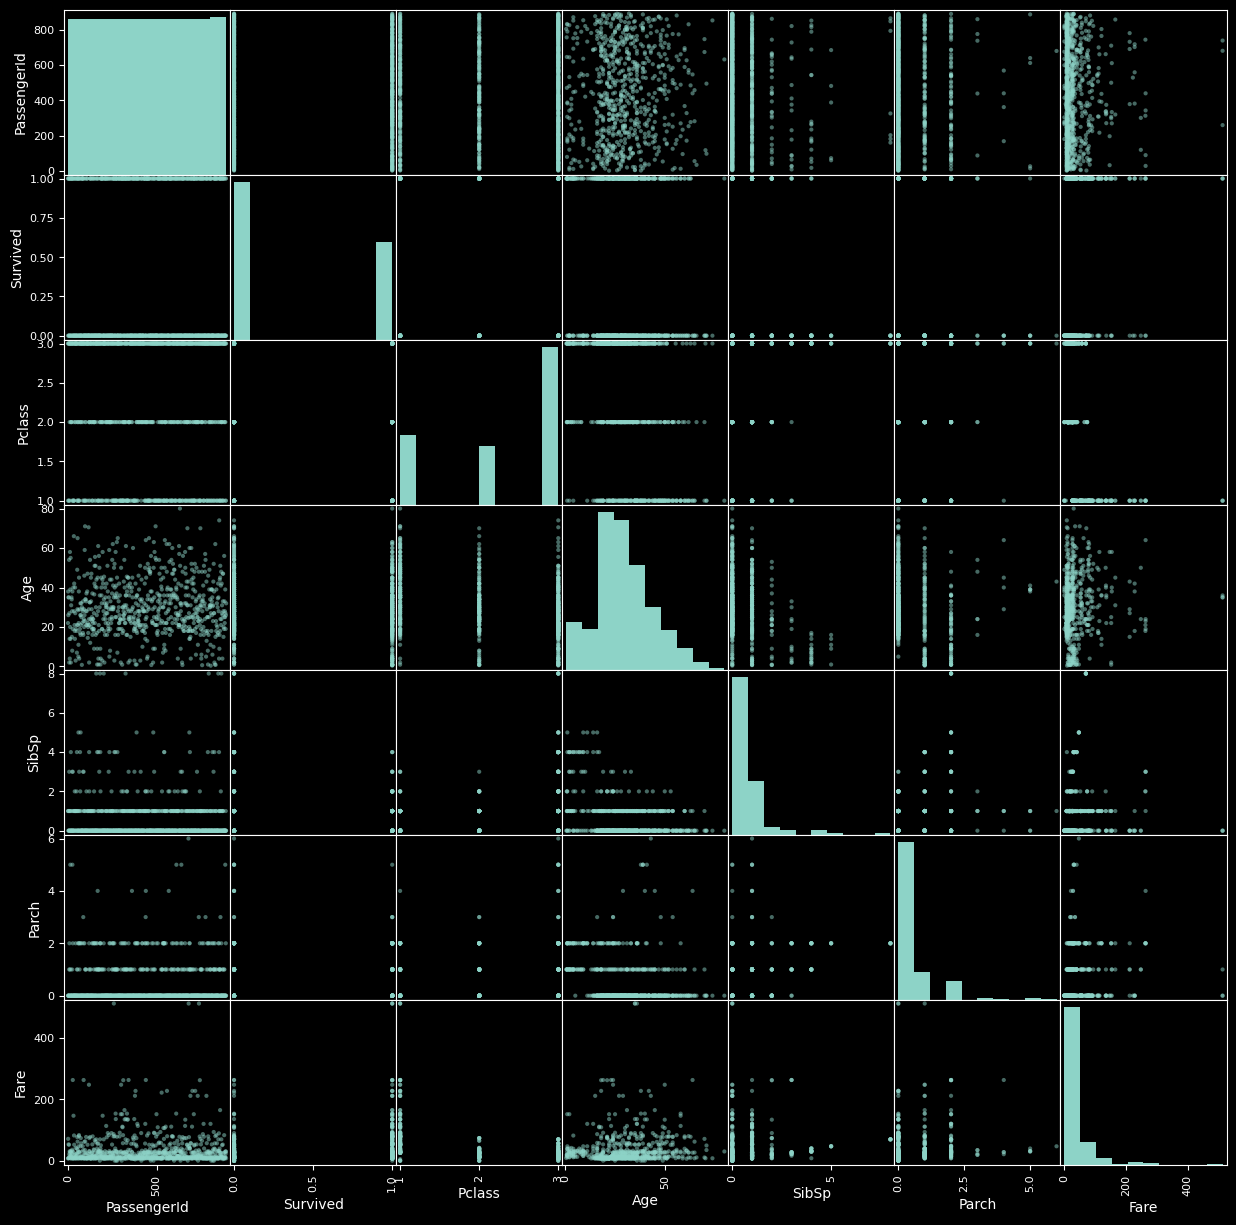

In [2]:
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt

scatter_matrix(df_train, figsize=(15, 15))
plt.show()

In [3]:
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True, sqrt=False):
        self.with_mean = with_mean
        self.sqrt = sqrt
        self.exp = 1

    def fit(self, X, y=None):
        X = check_array(X, ensure_all_finite=False)
        if self.sqrt:
            self.exp = 0.5
        self.mean_ = X.mean(axis=0)**self.exp
        self.scale_ = X.std(axis=0)**self.exp
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self, ['mean_', 'scale_'])
        X = check_array(X, ensure_all_finite=False)
        assert X.shape[1] == self.n_features_in_
        if self.with_mean:
            return (X**self.exp - self.mean_) / self.scale_
        return (X**self.exp - self.mean_) / self.scale_
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = [f'feature_{i}' for i in range(self.n_features_in_)]
        return input_features

In [4]:
class CombineFamilySize(BaseEstimator, TransformerMixin):
    def __init__(self, sibsp_col='SibSp', parch_col='Parch'):
        self.sibsp_col = sibsp_col
        self.parch_col = parch_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['FamilySize'] = X[self.sibsp_col] + X[self.parch_col] + 1
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return list(input_features) + ['FamilySize']

In [5]:
def sex_transformer(X):
    return np.where(X == 'male', 0, 1).reshape(-1, 1)

In [ ]:
## Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer


# PIPELINES
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')) # for categorical features as features: 'Embarked'
numcat_pipeline = make_pipeline(KNNImputer(n_neighbors=10), OneHotEncoder(handle_unknown='ignore')) # for categorical features as features: 'Pclass'
replace_pipeline = make_pipeline(FunctionTransformer(sex_transformer, validate=False, feature_names_out='one-to-one'), KNNImputer(n_neighbors=10)) # for replacing values as features: 'Sex'
sqrt_pipeline = Pipeline([('knnimputer',KNNImputer(n_neighbors=10)),                              
                            ('scaler', StandardScalerClone(with_mean=True, sqrt=True)),
                            ('round', FunctionTransformer(func = lambda x: x.round(1), feature_names_out='one-to-one')),]) # for numerical features as features: 'Age'
combine_pipeline = make_pipeline(CombineFamilySize(), KNNImputer(n_neighbors=10)) # for combining features: 'SibSp', 'Parch'
num_pipeline = make_pipeline(KNNImputer(n_neighbors=10), StandardScaler()) # for numerical features as features: 'SibSp', 'Parch', 'Fare'

preprocessor_train = ColumnTransformer([
    ('cat', cat_pipeline, ['Embarked']),
    ('numcat', numcat_pipeline, ['Pclass']),
    ('replace', replace_pipeline, ['Sex']),
    ('sqrt', sqrt_pipeline, ['Age']),
    ('combine', combine_pipeline, ['SibSp', 'Parch']),
    ('drop', 'drop', ['PassengerId','Name', 'Ticket', 'Cabin', 'Embarked', 'Pclass']),
], remainder='passthrough')

df_train_prepared = preprocessor_train.fit_transform(df_train)
print(preprocessor_train.get_feature_names_out())
df_train_prepared = pd.DataFrame(df_train_prepared, columns=preprocessor_train.get_feature_names_out())

#ToDo:
# - scale SibSp, Parch, Fare
# - scale age on another way
# - combine other features


['cat__Embarked_C' 'cat__Embarked_Q' 'cat__Embarked_S'
 'numcat__Pclass_1.0' 'numcat__Pclass_2.0' 'numcat__Pclass_3.0'
 'replace__Sex' 'sqrt__Age' 'combine__SibSp' 'combine__Parch'
 'combine__FamilySize' 'remainder__Survived' 'remainder__Fare']
['cat__Embarked_C' 'cat__Embarked_Q' 'cat__Embarked_S'
 'numcat__Pclass_1.0' 'numcat__Pclass_2.0' 'numcat__Pclass_3.0'
 'replace__Sex' 'sqrt__Age' 'combine__SibSp' 'combine__Parch'
 'combine__FamilySize' 'remainder__Fare']


In [9]:
## Correlation
corr_matrix = df_train_prepared.corr()
print(corr_matrix['remainder__Survived'].sort_values(ascending=False))

remainder__Survived    1.000000
replace__Sex           0.543351
numcat__Pclass_1.0     0.285904
remainder__Fare        0.257307
cat__Embarked_C        0.168240
numcat__Pclass_2.0     0.093349
combine__Parch         0.081629
combine__FamilySize    0.016639
cat__Embarked_Q        0.003650
combine__SibSp        -0.035322
sqrt__Age             -0.101487
cat__Embarked_S       -0.149683
numcat__Pclass_3.0    -0.322308
Name: remainder__Survived, dtype: float64


In [ ]:
## Model
from sklearn.ensemble import RandomForestClassifier

full_pipeline = Pipeline([
    ('pre', preprocessor_train),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),])

In [ ]:
## Choose and optimize
from sklearn.model_selection import GridSearchCV

param_grid = [{'pre__numcat__knnimputer__n_neighbors': [2, 5, 7], 'classifier__max_depth': [5, 10, 20]},
              {'pre__sqrt__scaler__sqrt': [True, False], 'classifier__n_estimators': [100, 200, 300]},
              {'pre__sqrt__scaler__sqrt': [True, False], 'classifier__max_depth': [5, 10, 20]},]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X, y)
cv_res_ = pd.DataFrame(grid_search.cv_results_)
cv_res_.sort_values(by='mean_test_score',ascending=False, inplace=True)
print(cv_res_.head(5))
best_params = grid_search.best_params_
print(best_params)

{'classifier__max_depth': 10, 'pre__sqrt__scaler__sqrt': False}


In [19]:
## Evaluate
model = grid_search.best_estimator_
feature_importances = model['classifier'].feature_importances_
for importance, feature in sorted(zip(feature_importances, X.columns), reverse=True):
    print(f'{feature}: {importance}')

Parch: 0.3101816608548383
Ticket: 0.19934529832402612
SibSp: 0.0779991674785036
Embarked: 0.058426297126069636
Fare: 0.03228223705398561
Cabin: 0.028100272950654318
Sex: 0.026550242022774586
Age: 0.01728587578260434
PassengerId: 0.017257849500280743
Name: 0.01588051933008338
Pclass: 0.008739234455096615


In [22]:
## Predict
from sklearn.metrics import confusion_matrix

y_pred = model.predict(df_test)
y_pred_train = model.predict(X)

conf_matrix_train = confusion_matrix(y, y_pred_train)
print(conf_matrix_train)
print(f'Accuracy: {((conf_matrix_train[0,0]+conf_matrix_train[1,1])/conf_matrix_train.sum()).round(2)}')

[[539  10]
 [ 44 298]]
Accuracy: 0.94


In [23]:
## Save
df_test['Survived'] = y_pred
df_test[['PassengerId', 'Survived']].to_csv('data/kaggle_titanic/submission.csv', index=False)